In [1]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def render_ep (boat_plot, index=-1, target=False):
    #true wind vector
    #starting point
    #target point
    #PENDING: spline connecting each point
    from matplotlib import pyplot as plt
    boat_plot=np.split(boat_plot,len(boat_plot)/2)
    boat_plot=np.array(boat_plot)
    # Scatter plot
    #light blue -> darker blue 
    target_plot=env.target_position
    x=boat_plot[:, 0]
    y=boat_plot[:, 1]
    weights = np.arange(1,boat_plot[:, 1].shape[0]+1)
    plt.scatter(x, y, c=weights, cmap='Blues')
    if index!=-1:
        plt.title(f"{index}-th episode")
    if target==True:
        plt.scatter(target_plot[0], target_plot[1],c='red')
    # Display the plot
    plt.show()
    #plt.xlim(min(x),max(x))
    #plt.ylim(min(y),max(y))


In [2]:
import numpy as np

class SailBoatEnvironment:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.35):
        self.step_num=0
        #self.true_wind_direction = np.random.uniform(0, 2*np.pi)
        #PENDING: starting boat pos + target pos kalytera na orizontai sthn init para sthn reset
        #kai h reset na ta pairnei apo tin init
        self.boat_position = np.array([0, 0])
        self.target_position = np.array([55,100])
        #self.target_position = np.array([np.random.uniform(-10, 10), np.random.uniform(-10, 10)])
        self.sail_configs = np.linspace(0, 1, 16) #16 allowed positions of the sail
        self.rudder_configs = np.linspace(-np.pi/4, np.pi/4, 16) #The values of -np.pi/4 and np.pi/4 are chosen to represent the limits of the rudder configuration. These values correspond to the maximum angles 
                                                                #that the rudder can be turned left and right from the center position.The choice of np.pi/4 as the maximum #
                                                                # angle is somewhat arbitrary, but it is a common choice in sailing and boating applications.
        self.target_possible_angles=np.rad2deg(np.linspace(0, 2*np.pi, 16))
        
        
        #self.q_table = np.zeros((16, 16, 3))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def reset(self):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.target_possible_angles
        #iii)ypologizei thn target angle, thn diakritopoiei se mia apo tis dekaksi times kai epistrefei to index
        #toy self.target_possible_angles
        self.step_num=0
        #self.true_wind_direction = self.target_possible_angles[0]
        self.true_wind_direction = np.random.choice(np.rad2deg(np.linspace(0, 2*np.pi, 16)))
        self.boat_position = np.array([0, 0]) #fixed starting point
        self.target_position = np.array([55,100]) #fixed target position
        self.max_distance=np.linalg.norm(self.boat_position-self.target_position)
        self.target_angle=angle_between(self.boat_position, self.target_position)
        self.target_angle=find_nearest(self.target_possible_angles, value=self.target_angle)
        return self.boat_position, np.where(self.true_wind_direction==self.target_possible_angles)[0][0], \
        np.where(self.target_angle==self.target_possible_angles)[0][0]
        
        

    def get_state(self):
        relative_wind_direction = self.true_wind_direction - np.arctan2(*self.boat_position[::-1])
        #relative_wind_direction = find_nearest(self.target_possible_angles, value=relative_wind_direction)
        distance_to_target = np.linalg.norm(self.boat_position - self.target_position)
        return relative_wind_direction, distance_to_target

    def step(self, action):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.target_possible_angles
        #iii)ypologizei thn target angle, thn diakritopoiei se mia apo tis dekaksi times kai epistrefei to index
        #toy self.target_possible_angles
        #iv) step reward
        #v) done status
        #vi) truncated status
        #vii) number of steps
        sail_config, rudder_config = action
        sail_force = sail_config * np.sin(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        rudder_force = rudder_config * np.cos(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        boat_velocity = np.array([np.cos(self.true_wind_direction), np.sin(self.true_wind_direction)]) * sail_force + np.array([-np.sin(self.true_wind_direction), np.cos(self.true_wind_direction)]) * rudder_force
        self.boat_position = self.boat_position + boat_velocity#.astype(np.float64)
        self.target_angle=angle_between(self.boat_position, self.target_position)
        self.target_angle=find_nearest(self.target_possible_angles, value=self.target_angle)
        
        state = self.get_state()
        self.step_num+=1
        done = False
        truncated = False
        reward = -1

        #if np.any(np.abs(self.boat_position) > 20):
            #done = True
            #reward = -10

        distance_to_target = state[1]
        if distance_to_target < 1:
        #if distance_to_target//self.max_distance < 0.5: #kapws pio sxetiko giati den kseroume to distance 0.5
            #an einia megalo h mikro
            done = True
            reward = 100
        
        if self.step_num >= 1_000:
            truncated = True
            #done = True #gia na spaei h loupa tou training

#         # Q-learning update
#         sail_idx = np.argmin(np.abs(self.sail_configs - sail_config))
#         rudder_idx = np.argmin(np.abs(self.rudder_configs - rudder_config))
#         q_current = self.q_table[sail_idx, rudder_idx, 0]
#         q_next = np.max(self.q_table[sail_idx, rudder_idx, :])
#         self.q_table[sail_idx, rudder_idx, 0] += self.alpha * (reward + self.gamma * q_next - q_current)

        #return boat_velocity, self.boat_position, state, reward, done, self.step_num, self.target_angle
        return self.boat_position, np.where(self.true_wind_direction==self.target_possible_angles)[0][0],\
        np.where(self.target_angle==self.target_possible_angles)[0][0], reward, \
        done, truncated, self.step_num


In [3]:
# env=SailBoatEnvironment()
# np.linalg.norm(env.boat_position-env.target_position)
#OUTPUT= 114.12712210513327 units

# Plot random movement

In [4]:
# env=SailBoatEnvironment()
# env.reset()
# done=False
# truncated=False
# boat_plot=[]
# while not truncated:
#     mlist=np.random.choice(np.linspace(0, 1, 16)), np.random.choice(np.linspace(-np.pi/4, np.pi/4, 16))
#     boat_pos, true_wind_index, target_angle_index,  reward, done, truncated, step_num = env.step(mlist)
#     #print(truncated)
#     boat_plot=np.append(boat_plot,np.array(boat_pos))
# #print(step_num)
# #boat_plot
# render_ep(boat_plot)

# Start env & Define Q Table

In [5]:
env=SailBoatEnvironment()
#current state = true wind direction + angle of boat to target wrt x axis
#prwto einai gia true wind angles
a=len(env.target_possible_angles)
#deytera gia gwnies pros target
#trito ola ta possible actions
b=32
q_table = np.random.uniform(low=-2, high=0, size=(a,a,b))
#q_table
#wd=0,1,2 # wd=1
#dt=0,1 #dt=0 makria, dt=1 konta
#np.argmax(q_table[1,1])
#
#rudder conf = 0:15th column
#np.argmax(q_table[state,0:15])
#sail conf = 16:31th columns
#np.argmax(q_table[state,16:32])



In [6]:
index=np.arange(1,100,10)

In [7]:
index

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [8]:
index[0:5]

array([ 1, 11, 21, 31, 41])

In [9]:
index[5:10]

array([51, 61, 71, 81, 91])

In [10]:
np.argmax(index[5:10])

4

In [11]:
index[5+4]

91

In [12]:
current_state=env.reset()
current_state=current_state[1], current_state[2]
np.argmax(q_table[(current_state)][16:33])

10

# Train Q table

0-th ep -> steps: 1000
45-th ep -> Egina done
419-th ep -> Egina done
459-th ep -> Egina done
800-th ep -> steps: 1000
1256-th ep -> Egina done
1280-th ep -> Egina done
1300-th ep -> Egina done
1315-th ep -> Egina done
1318-th ep -> Egina done
1321-th ep -> Egina done
1323-th ep -> Egina done
1344-th ep -> Egina done
1393-th ep -> Egina done
1398-th ep -> Egina done
1408-th ep -> Egina done
1427-th ep -> Egina done
1439-th ep -> Egina done
1453-th ep -> Egina done
1502-th ep -> Egina done
1535-th ep -> Egina done
1551-th ep -> Egina done
1552-th ep -> Egina done
1566-th ep -> Egina done
1588-th ep -> Egina done
1600-th ep -> steps: 1000
1604-th ep -> Egina done
1627-th ep -> Egina done
1658-th ep -> Egina done
1679-th ep -> Egina done
1711-th ep -> Egina done
1726-th ep -> Egina done
1764-th ep -> Egina done
1784-th ep -> Egina done
1805-th ep -> Egina done
1820-th ep -> Egina done
1846-th ep -> Egina done
1856-th ep -> Egina done
1886-th ep -> Egina done
1948-th ep -> Egina done
1967-

7922-th ep -> Egina done
7991-th ep -> Egina done
7997-th ep -> Egina done
8000-th ep -> steps: 1000
8001-th ep -> Egina done
8026-th ep -> Egina done
8027-th ep -> Egina done
8036-th ep -> Egina done
8093-th ep -> Egina done
8094-th ep -> Egina done
8126-th ep -> Egina done
8149-th ep -> Egina done
8177-th ep -> Egina done
8178-th ep -> Egina done
8179-th ep -> Egina done
8200-th ep -> Egina done
8216-th ep -> Egina done
8238-th ep -> Egina done
8259-th ep -> Egina done
8289-th ep -> Egina done
8337-th ep -> Egina done
8345-th ep -> Egina done
8354-th ep -> Egina done
8357-th ep -> Egina done
8362-th ep -> Egina done
8381-th ep -> Egina done
8389-th ep -> Egina done
8415-th ep -> Egina done
8420-th ep -> Egina done
8448-th ep -> Egina done
8455-th ep -> Egina done
8472-th ep -> Egina done
8555-th ep -> Egina done
8579-th ep -> Egina done
8581-th ep -> Egina done
8599-th ep -> Egina done
8613-th ep -> Egina done
8625-th ep -> Egina done
8642-th ep -> Egina done
8645-th ep -> Egina done

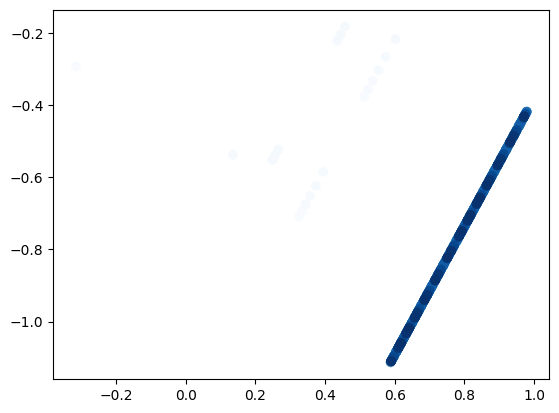

In [13]:
env=SailBoatEnvironment()
EPISODES=10_000
tw_direction=[]
boat_plot=[]
boat_plot_all_ep=[] #stores all episodes' movement
dones=np.zeros(EPISODES)
for i in range(EPISODES):
    boat_plot=[]
    current_state=env.reset()    
    current_state=current_state[1], current_state[2]
    tw_direction=np.append(tw_direction,current_state[0])
    done=False
    truncated=False
    while not done: # or not truncated:
    #rudder_conf=env.rudder_configs[rudder_conf_index]
    #rudder_conf
        sail_conf_index=np.argmax(q_table[(current_state)][0:16])
        rudder_conf_index=np.argmax(q_table[(current_state)][16:33])
        #print(f"{i} ep: sail index->{sail_conf_index}, rudder index->{rudder_conf_index}")
        #H np.argmax epistrefei index, oxi timh, opote pairnoume to index pou mas epistrefei
        #kai blepoume apo ta *_configs poia timh antistoixei se ayto to index
        action=env.sail_configs[sail_conf_index],env.rudder_configs[rudder_conf_index]
        boat_pos,  true_wind_index, target_angle_index, reward, done, truncated, step_num = env.step(action)
        if done==True:
            print(f"{i}-th ep -> Egina done")
            dones[i]=1
            break
        if truncated==True:
            #print(f"{i}-th ep -> Egina truncated")
            break
        new_state=true_wind_index, target_angle_index
        boat_plot=np.append(boat_plot,np.array(boat_pos))
        
        #Psaxnoume ta Q_max, ena gia to sail setting kai ena gia to rudder setting
        #Sto Q table exoume orisei aythaireta oti oi prwtes 16 columns [0:16] dhladh
        #antistoixoun sto sail setting
        #enw oi ypoloipes 16 columns [16:33] sto rudder config
        Q_max_sail=np.max(q_table[(current_state)][0:16])
        Q_max_rudder=np.max(q_table[(current_state)][16:33])
        q_current_sail=q_table[current_state+(sail_conf_index,)]
        q_current_rudder=q_table[current_state+(rudder_conf_index,)]
        new_q_sail=(1-env.alpha)*q_current_sail+env.alpha*(reward+env.gamma*Q_max_sail)
        new_q_rudder=(1-env.alpha)*q_current_rudder+env.alpha*(reward+env.gamma*Q_max_rudder)
        q_table[current_state+(sail_conf_index,)]=new_q_sail
        q_table[current_state+(15+rudder_conf_index,)]=new_q_rudder
        current_state=new_state

    #print(i)
    boat_plot_all_ep.append(boat_plot)
    if i%800==0:
        print(f"{i}-th ep -> steps: {step_num}")
    
#plot last episode
render_ep(boat_plot, -1)

In [14]:
# boat_array=np.split(boat_plot,len(boat_plot)/2)
# boat_array=np.array(boat_array)
# boat_array

In [16]:
dones
#Count number of successful episodes
num_successful_episodes=np.count_nonzero(dones == 1)
#Index of successful episodes
successful_indices=np.where(dones==1)[0]
print(f"posa epeisodia teleiwsa: {num_successful_episodes} apo ta {i} \ndhladh to {round(num_successful_episodes/i,2)*100}%")

posa epeisodia teleiwsa: 365 apo ta 9999 
dhladh to 4.0%


In [17]:
#Vlepoume oti oloklhrwnei epeisodia mono otan to wind direction einai sygkekrimeno

tw_direction[successful_indices]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

# Plot some episodes that reached target

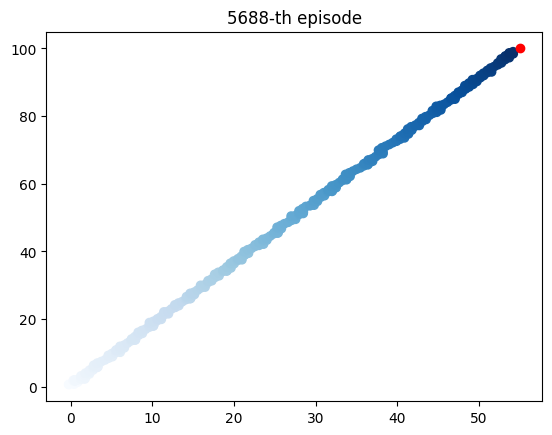

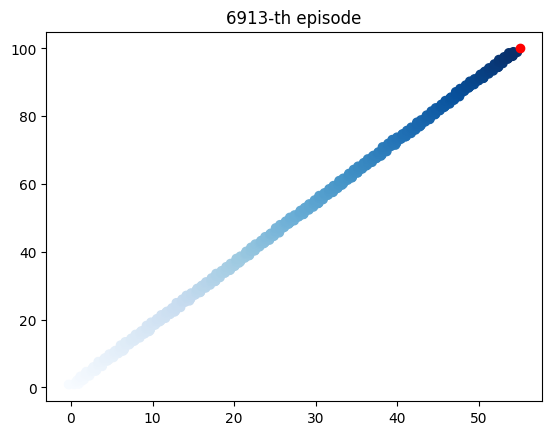

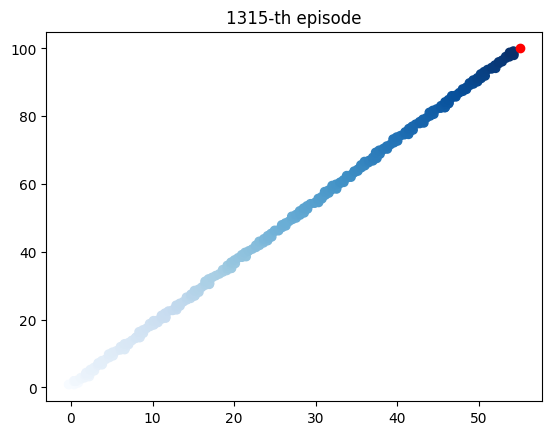

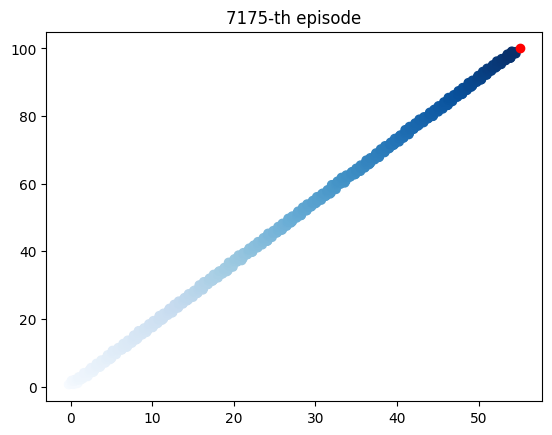

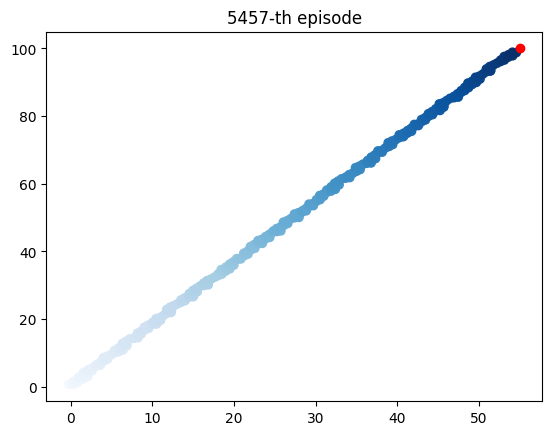

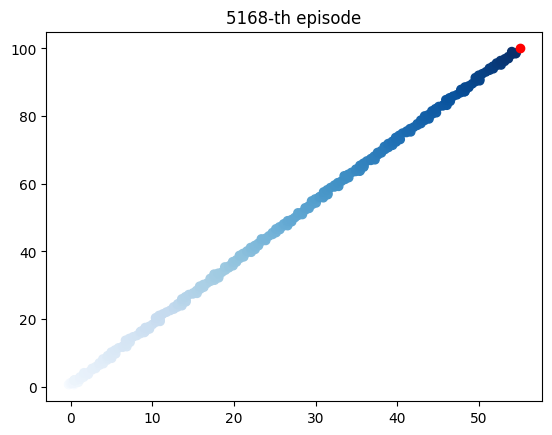

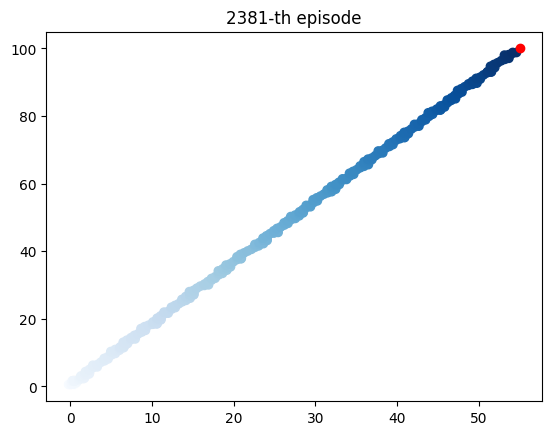

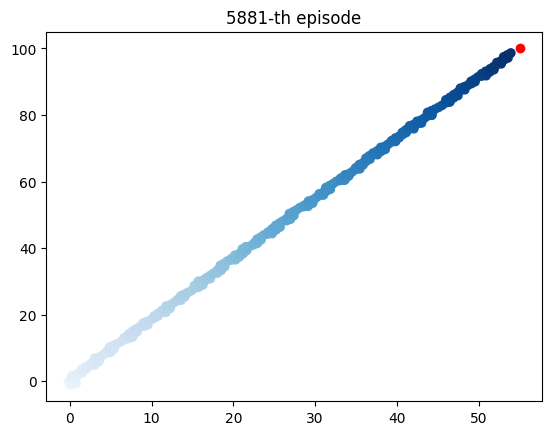

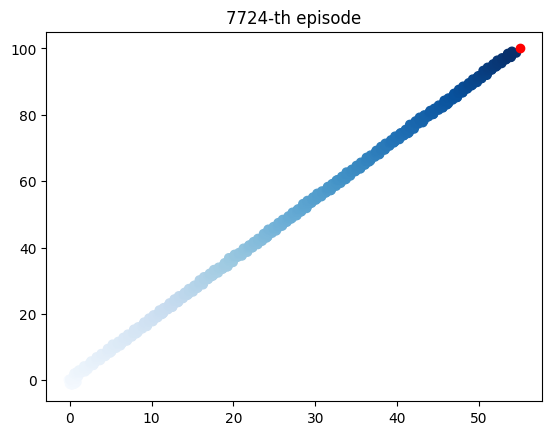

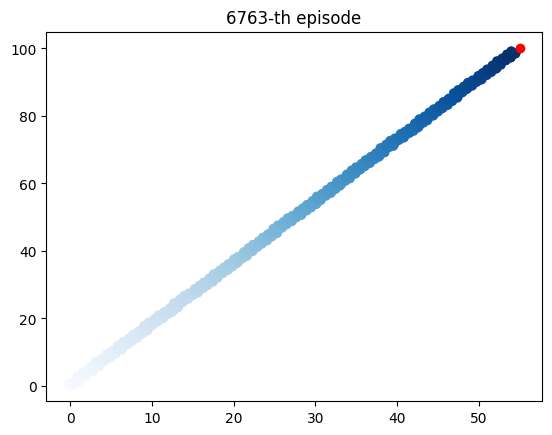

In [18]:
for i in np.random.choice(successful_indices, size=10, replace=True):
     render_ep(boat_plot_all_ep[i], i, True)

# Plot every 1000 episodes

In [ ]:
for i in np.arange(0,EPISODES, 1000):
    render_ep(boat_plot_all_ep[i], i)

# Test Q Table

In [ ]:
# env=SailBoatEnvironment()
# for i in range(100):
#     current_state=env.reset()
#     current_state=current_state[1], current_state[2]
#     done=False
#     while not done:
#     #rudder_conf=env.rudder_configs[rudder_conf_index]
#     #rudder_conf
#         sail_conf_index=np.argmax(q_table[(current_state)][0:15])
#         rudder_conf_index=np.argmax(q_table[(current_state)][15:33])
#         #sail_conf=env.sail_configs[sail_conf_index]
#         #sail_conf
#         action=env.sail_configs[sail_conf_index],env.rudder_configs[15-rudder_conf_index]
#         boat_pos,  true_wind_index, target_angle_index, reward, done, truncated, step_num = env.step(action)
#         new_state=true_wind_index, target_angle_index
#         #plotting a single episode
#         #boat_plot=np.append(boat_plot,np.array(boat_pos))
# #         Q_max_sail=np.max(q_table[(current_state)][0:15])
# #         Q_max_rudder=np.max(q_table[(current_state)][15:33])
# #         q_current_sail=q_table[current_state+(sail_conf_index,)]
# #         q_current_rudder=q_table[current_state+(15+sail_conf_index,)]
# #         new_q_sail=(1-env.alpha)*q_current_sail+env.alpha*(reward+env.gamma*Q_max_sail)
# #         new_q_rudder=(1-env.alpha)*q_current_rudder+env.alpha*(reward+env.gamma*Q_max_rudder)
# #         q_table[current_state+(sail_conf_index,)]=new_q_sail
# #         q_table[current_state+(15+sail_conf_index,)]=new_q_rudder
#         current_state=new_state
#     if i%5==0:
#         print(f"{i}-th ep -> steps: {step_num}")

In [ ]:
# env=SailBoatEnvironment()
# q_table = np.zeros((16, 16, 3))

# num_episodes = 1
# #num_steps = 1000
# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     total_reward = 0
#     while not done:
#         # Choose action using epsilon-greedy policy
        
#         #if np.random.uniform() < env.epsilon:
#             #action = [np.random.choice(env.sail_configs), np.random.choice(env.rudder_configs)]
#         #else:
#         sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#         action = [env.sail_configs[sail_idx], env.rudder_configs[rudder_idx]]
        
#         # Take action
#         boat_v, boat_pos, next_state, reward, done, step_number = env.step(action)
        
#         # Update Q-table
#         sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#         q_current = q_table[sail_idx, rudder_idx, 0]
#         q_next = np.max(q_table[sail_idx, rudder_idx, :])
#         q_table[sail_idx, rudder_idx, 0] += env.alpha * (reward + env.gamma * q_next - q_current)
        
#         state = next_state
#         total_reward += reward
#         #print(f"Step: {step_number}, BoatV:{np.round(boat_v,2)} , Boat Pos:{np.round(boat_pos,2)}")
#     #print(f"Episode {episode+1}, BoatV:{boat_v} , Boat Pos:{boat_pos}")


In [ ]:
# import matplotlib.pyplot as plt

# env = SailBoatEnvironment()
# num_episodes = 3000
# num_steps =1000

# # create empty arrays to store positions for each episode
# boat_positions = np.zeros((num_episodes, 2)) 
# target_positions = np.tile(np.array([55,100]), (num_episodes, 1))

# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     total_reward = 0
#     while not done:
#         # Choose action using epsilon-greedy policy
#         if np.random.uniform() < env.epsilon:
#             action = [np.random.choice(env.sail_configs), np.random.choice(env.rudder_configs)]
#         else:
#             sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#             action = [env.sail_configs[sail_idx], env.rudder_configs[rudder_idx]]

#         # Take action
#         boat_v, boat_pos, next_state, reward, done = env.step(action)
        

#         # Update Q-table
#         sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
#         q_current = q_table[sail_idx, rudder_idx, 0]
#         q_next = np.max(q_table[sail_idx, rudder_idx, :])
#         q_table[sail_idx, rudder_idx, 0] += env.alpha * (reward + env.gamma * q_next - q_current)

#         state = next_state
#         total_reward += reward
    
#     # store final position in boat_positions array
#     boat_positions[episode, :] = state
    
#     print(f"Episode {episode+1}, Total reward: {total_reward}, New Position: ({state[0]:.2f}, {state[1]:.2f}), Target Position: ({env.target_position[0]:.2f}, {env.target_position[1]:.2f})")

# # create scatter plot of boat positions and target positions
# fig, ax = plt.subplots()
# ax.scatter(target_positions[:, 0], target_positions[:, 1], color='red',label='Target Position')
# ax.scatter(boat_positions[:, 0], boat_positions[:, 1], color='gray', label='Boat Position')
# ax.legend()
# plt.show()


the Q-table is a 3-dimensional numpy array with dimensions (11, 11, 3). The first two dimensions correspond to the sail and rudder configurations, respectively, and the third dimension corresponds to the Q-values for each possible action (there are 3 actions in total: sail left, sail straight, and sail right).

self.true_wind_direction is a random value between 0 and 2π.
self.boat_position is a NumPy array containing the initial position of the boat, which is (0, 0).
self.target_position is a NumPy array containing the position of the target, which is a random point within a rectangle centered at the origin with width and height of 20 units.
self.sail_configs is a NumPy array containing 11 equally spaced values between 0 and 1, representing the possible sail configurations.
self.rudder_configs is a NumPy array containing 11 equally spaced values between -π/4 and π/4, representing the possible rudder configurations.
self.q_table is a 3-dimensional NumPy array of zeros with shape (11, 11, 3), representing the Q-values for each possible combination of sail and rudder configurations.

sail_idx = np.argmin(np.abs(self.sail_configs - sail_config)) finds the index of the sail configuration that is closest to the desired sail configuration specified by sail_config. This is used to index into the first dimension of the Q-table.

rudder_idx = np.argmin(np.abs(self.rudder_configs - rudder_config)) finds the index of the rudder configuration that is closest to the desired rudder configuration specified by rudder_config. This is used to index into the second dimension of the Q-table.

q_current = self.q_table[sail_idx, rudder_idx, 0] retrieves the current Q-value for the current state and action (which is the "sail straight" action, corresponding to the index 0 in the third dimension).

q_next = np.max(self.q_table[sail_idx, rudder_idx, :]) computes the estimated Q-value for the next state, which is the maximum Q-value over all possible actions in the next state (i.e., the action that maximizes the Q-value). This is used to estimate the expected total reward that can be obtained from the next state.

self.q_table[sail_idx, rudder_idx, 0] += self.alpha * (reward + self.gamma * q_next - q_current) updates the Q-value for the current state and action, using the Q-learning update rule

The Q-learning update equation is used to update the Q-value for the current state and action. The Q-value for the current state and action is q_current, and q_next is the maximum Q-value for the next state. The update is performed as follows:

new_q_value = old_q_value + learning_rate * (reward + discount_factor * max_q_next - old_q_value)

where learning_rate is the step size, reward is the reward obtained from the current action, discount_factor is the discount factor for future rewards, and max_q_next is the maximum Q-value for the next state.

In the code, q_current is the current Q-value for the current state and action, and q_next is the maximum Q-value for the next state. The Q-value for the current state and action is updated using the above equation, and the new value is stored back in the Q-table.

relative_wind_direction = self.true_wind_direction - np.arctan2(*self.boat_position[::-1])
self.true_wind_direction: This is a scalar value that represents the direction of the wind, expressed in radians.
np.arctan2(*self.boat_position[::-1]): This is a function call to np.arctan2, which computes the arctangent of the ratio of two given inputs. In this case, the inputs are the components of the boat's position vector, reversed using [::-1]. The * before self.boat_position[::-1] unpacks the tuple of components into separate arguments for the np.arctan2 function. The resulting output is the angle in radians between the positive x-axis and a line connecting the boat's position to the origin.
self.true_wind_direction - np.arctan2(*self.boat_position[::-1]): This subtracts the angle from step 2 from the wind direction angle from step 1, resulting in the relative wind direction, which is the angle in radians between the boat's heading and the direction of the wind.
Overall, this line of code is computing the relative wind direction, which is an important parameter for calculating the sail force applied to the boat in the subsequent lines of code.